# Определение возраста покупателей

## Исследовательский анализ данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from pandas import read_csv as r_c

Загрузка датасета

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

Отобразим размер выборки

In [3]:
df.shape

(7591, 2)

В наличии имеется незначительное количество данных, в следствие чего мы должны использовать предобученные веса для backbone. Необоходимо протестировать, в каком случае модель будет давать наилучшие результаты - с замороженной верхушкой backbonе или без.

График распределения возраста в выборке

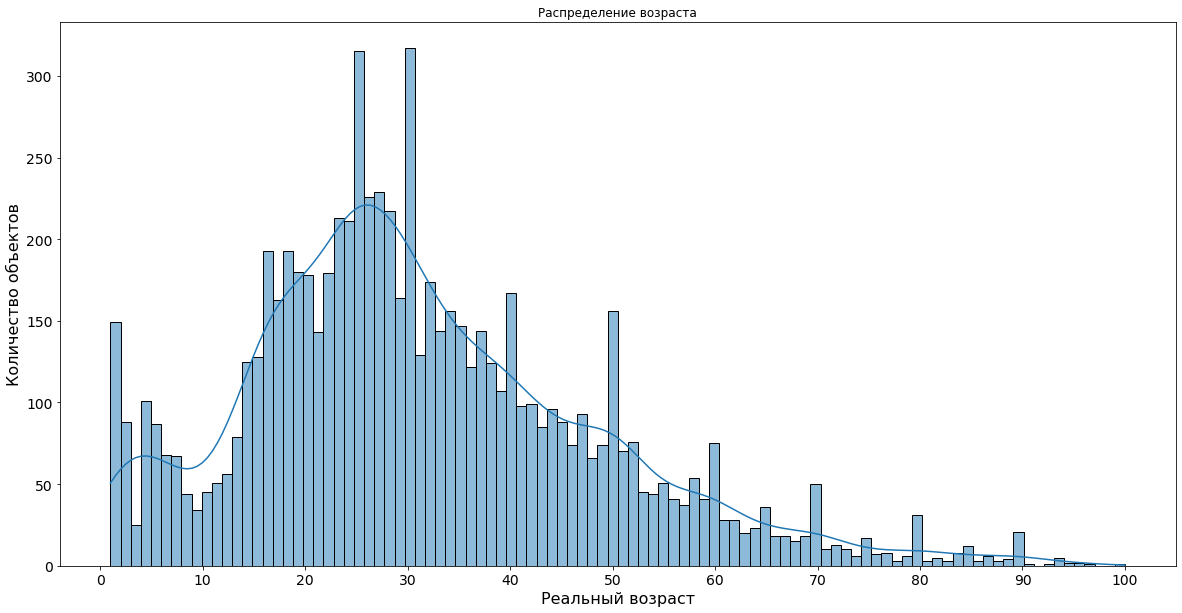

In [4]:
plt.rcParams['figure.figsize']=(20,10)
plt.title('Распределение возраста')
sns.histplot(df['real_age'], bins=100, kde=True)
plt.xlabel('Реальный возраст', fontsize=16)
plt.ylabel('Количество объектов', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(range(0, 101, 10))
plt.show();

Заметно преобладание средней возрастной группы над двумя другими. Данное распределение нельзя считать нормальным. Обнаружены всплески данных на уровнях лет, что соответствуют юбилейным годам (1, 25, 30, 40, 50, 60, 70, 80, 90), это может свидетельствовать о недобросовестной разметке исходных данных.

In [5]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0)
gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


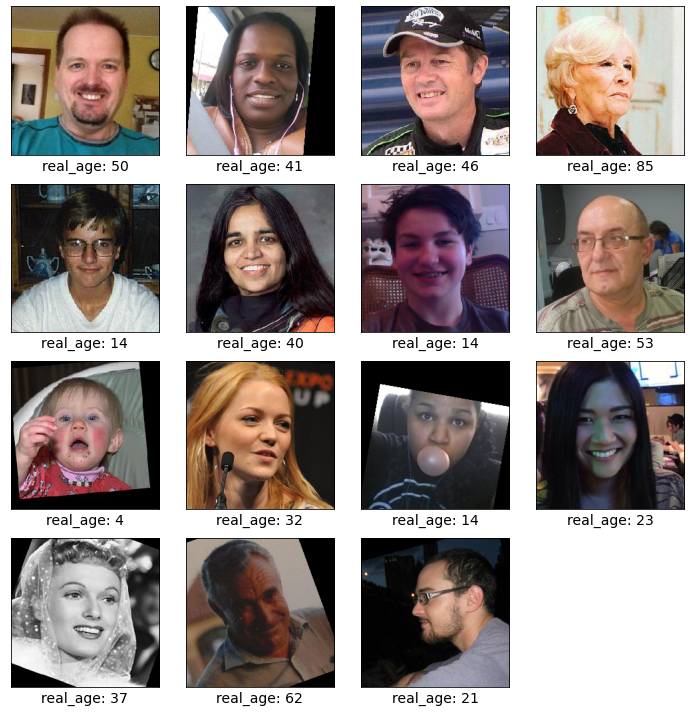

In [6]:
features, labels = next(gen_flow)
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xlabel(f'real_age: {labels[i]}', fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) обнаружено:</b></div>

- В наличии имеется незначительное количество данных, в следствие чего мы должны использовать предобученные веса для backbone. Необоходимо протестировать, в каком случае модель будет давать наилучшие результаты - с замороженной верхушкой backbonе или без.
- Преобладание средней возрастной группы над двумя другими. Данное распределение нельзя считать нормальным. Обнаружены всплески данных на уровнях лет, что соответствуют юбилейным годам (1, 25, 30, 40, 50, 60, 70, 80, 90), это может свидетельствовать о недобросовестной разметке исходных данных..
- Можно говорить о фотографиях разного качества, некоторые из них имеют смещение, повернуты на разное количество градусов, так же можно отметить разный масштаб фотографий(где-то очень тяжело отчетливо проследить черты лица), где-то часть лица может быть закрыта, а на некоторых фотографиях видна лишь часть лица.
- Для того, чтобы наша модель находила не только "геометрические закономерности", а более сложные зависимости, применим различные виды аугментаций при обучении модели, данное действие повысит обобщающую способность нашей модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from pandas import read_csv as r_c
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1 / 255, horizontal_flip=True, zoom_range=0.1, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=r_c(path + 'labels.csv'),
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training')

    return train_gen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1 / 255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=r_c(path + 'labels.csv'),
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation')

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    # замораживаем ResNet50 без верхушки
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=50,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/50
2023-07-12 11:07:31.520845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-12 11:07:32.540518: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 131s - loss: 229.3882 - mae: 10.9369 - val_loss: 870.2495 - val_mae: 24.6305
Epoch 2/50
178/178 - 102s - loss: 81.9468 - mae: 6.8603 - val_loss: 781.0444 - val_mae: 22.9571
Epoch 3/50
178/178 - 102s - loss: 57.6656 - mae: 5.7970 - val_loss: 233.7587 - val_mae: 11.5139
Epoch 4/50
178/178 - 101s - loss: 45.9482 - mae: 5.1708 - val_loss: 112.6139 - val_mae: 8.0454
Epoch 5/50
178/178 - 104s - loss: 35.1965 - mae: 4.5686 - val_loss: 76.8483 - val_mae: 6.6644
Epoch 6/50
178/178 - 99s - loss: 30.5601 - mae: 4.2629 - val_loss: 154.5308 - val_mae: 9.5522
Epoch 7/50
178/178 - 91s - loss: 27.1431 - mae: 3.9935 - val_loss: 78.9650 - val_mae: 6.7742
Epoch 8/50
178/178 - 91s - loss: 21.2553 - mae: 3.5884 - val_loss: 71.7719 - val_mae: 6.2585
Epoch 9/50
178/178 - 92s - loss: 18.0310 - mae: 3.2860 - val_loss: 64.8833 - val_mae: 5.9420
Epoch 10/50
178/178 - 94s - loss: 16.0834 - mae: 3.0782 - val_loss: 63.1444 - val_mae: 6.0058
Epoch 11/50
178/178 - 99s - loss: 14.4671 - mae: 2.9387 - val_loss: 100.1730 - val_mae: 7.2253
Epoch 12/50
178/178 - 99s - loss: 13.5194 - mae: 2.8458 - val_loss: 59.9510 - val_mae: 5.8148
Epoch 13/50
178/178 - 98s - loss: 11.4283 - mae: 2.5966 - val_loss: 67.6188 - val_mae: 6.1153
Epoch 14/50
178/178 - 98s - loss: 10.8662 - mae: 2.5499 - val_loss: 64.4994 - val_mae: 5.9382
Epoch 15/50
178/178 - 100s - loss: 10.6432 - mae: 2.4899 - val_loss: 61.9478 - val_mae: 5.7842
Epoch 16/50
178/178 - 99s - loss: 9.6889 - mae: 2.3797 - val_loss: 61.5784 - val_mae: 5.9121
Epoch 17/50
178/178 - 97s - loss: 9.5089 - mae: 2.3656 - val_loss: 68.9409 - val_mae: 6.1065
Epoch 18/50
178/178 - 98s - loss: 8.9214 - mae: 2.2926 - val_loss: 66.9965 - val_mae: 5.9620
Epoch 19/50
178/178 - 97s - loss: 8.2072 - mae: 2.1963 - val_loss: 59.8332 - val_mae: 5.7533
Epoch 20/50
178/178 - 92s - loss: 8.2876 - mae: 2.1998 - val_loss: 63.2932 - val_mae: 5.7926
Epoch 21/50
178/178 - 91s - loss: 8.5280 - mae: 2.2279 - val_loss: 65.6298 - val_mae: 6.1860
Epoch 22/50
178/178 - 91s - loss: 8.3454 - mae: 2.1884 - val_loss: 61.0038 - val_mae: 5.7312
Epoch 23/50
178/178 - 91s - loss: 7.9738 - mae: 2.1610 - val_loss: 57.9017 - val_mae: 5.6669
Epoch 24/50
178/178 - 92s - loss: 7.4770 - mae: 2.1185 - val_loss: 59.2687 - val_mae: 5.6575
Epoch 25/50
178/178 - 93s - loss: 7.2673 - mae: 2.0569 - val_loss: 64.3472 - val_mae: 5.9338
Epoch 26/50
178/178 - 102s - loss: 7.0689 - mae: 2.0516 - val_loss: 61.6766 - val_mae: 5.7398
Epoch 27/50
178/178 - 102s - loss: 7.5169 - mae: 2.0755 - val_loss: 64.8182 - val_mae: 6.1220
Epoch 28/50
178/178 - 104s - loss: 7.7316 - mae: 2.0861 - val_loss: 62.4367 - val_mae: 5.8304
Epoch 29/50
178/178 - 103s - loss: 7.8578 - mae: 2.1194 - val_loss: 58.3332 - val_mae: 5.6410
Epoch 30/50
178/178 - 103s - loss: 7.9828 - mae: 2.1126 - val_loss: 62.7683 - val_mae: 5.7761
Epoch 31/50
178/178 - 98s - loss: 7.6271 - mae: 2.0826 - val_loss: 60.0216 - val_mae: 5.6221
Epoch 32/50
178/178 - 92s - loss: 7.3323 - mae: 2.0590 - val_loss: 58.9382 - val_mae: 5.7421
Epoch 33/50
178/178 - 92s - loss: 7.1232 - mae: 2.0294 - val_loss: 55.7182 - val_mae: 5.5149
Epoch 34/50
178/178 - 91s - loss: 6.1670 - mae: 1.8816 - val_loss: 68.8490 - val_mae: 6.0031
Epoch 35/50
178/178 - 92s - loss: 5.8281 - mae: 1.8699 - val_loss: 59.1443 - val_mae: 5.7234
Epoch 36/50
178/178 - 92s - loss: 5.8198 - mae: 1.8476 - val_loss: 58.2431 - val_mae: 5.6187
Epoch 37/50
178/178 - 91s - loss: 6.2244 - mae: 1.9169 - val_loss: 58.4593 - val_mae: 5.5881
Epoch 38/50
178/178 - 92s - loss: 5.7956 - mae: 1.8275 - val_loss: 62.9849 - val_mae: 5.7095
Epoch 39/50
178/178 - 90s - loss: 5.6371 - mae: 1.7937 - val_loss: 58.8914 - val_mae: 5.5971
Epoch 40/50
178/178 - 92s - loss: 5.6741 - mae: 1.8008 - val_loss: 56.8549 - val_mae: 5.4477
Epoch 41/50
178/178 - 92s - loss: 5.2960 - mae: 1.7561 - val_loss: 55.1629 - val_mae: 5.4149
Epoch 42/50
178/178 - 91s - loss: 7.3367 - mae: 2.0342 - val_loss: 62.4547 - val_mae: 5.8913
Epoch 43/50
178/178 - 91s - loss: 6.1102 - mae: 1.8642 - val_loss: 58.3881 - val_mae: 5.6460
Epoch 44/50
178/178 - 91s - loss: 5.6487 - mae: 1.7999 - val_loss: 57.8061 - val_mae: 5.6999
Epoch 45/50
178/178 - 92s - loss: 5.2808 - mae: 1.7385 - val_loss: 56.1305 - val_mae: 5.4628
Epoch 46/50
178/178 - 89s - loss: 7.7049 - mae: 2.0797 - val_loss: 62.4942 - val_mae: 5.9163
Epoch 47/50
178/178 - 87s - loss: 5.7864 - mae: 1.8295 - val_loss: 56.1640 - val_mae: 5.6052
Epoch 48/50
178/178 - 87s - loss: 4.7710 - mae: 1.6628 - val_loss: 54.8902 - val_mae: 5.3672
Epoch 49/50
178/178 - 87s - loss: 4.2776 - mae: 1.5605 - val_loss: 56.9567 - val_mae: 5.5998
Epoch 50/50
178/178 - 88s - loss: 4.0051 - mae: 1.5233 - val_loss: 55.7182 - val_mae: 5.3966
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 55.7182 - mae: 5.3966
Test MAE: 5.3966

```

## Анализ обученной модели

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) выполнено:</b></div>

- Произведено обучение ResNet50 модели с использованием предобученных весов для решения задачи регрессии.
- Выбранные параметры обучения: optimizer - Adam(lr-0.0001), 50 эпох, размер батча был равен 32, использованы 2 вида случайной аугментации - отражение по горизонтали и приближение на 0.1, модель обучена без заморозки верхушки весов базовых блоков.
- После 30 эпохи отмечено замедлиние снижения ключевой метрики MAE.
- Достигнут результат по выбранной ключевой метрике - MAE: 5.3966.
- Так как полученное значение средней абсолютной ошибки составляет ~5.4 года, то с точки зрения бизнеса мы можем решать поставленную задачу:
    - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
- Решение задачи: "контролировать добросовестность кассиров при продаже алкоголя" не представляетcя возможным, так как на стыке значений возраста, когда допустима продажа алкоголя и когда алкоголь продавать запрещено будут возникать ошибочные показания модели. И так как данные в нашей выборке смещены в сторону средней возрастной группы, то модель с большей вероятностью будет присваивать анализируемым лицам младше 18 лет возраст больше, чем есть им на самом деле, в следствие чего адекватный контроль продажи алкоголя с помощью данного решения не представляется возможным.